In [358]:
import numpy as np
import pandas as pd
import scipy
from sklearn import cross_validation, datasets, linear_model 

from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods implementation

### Likelihood function

In [359]:
def likelihood_function(X, y, w): # inversed
    vec = np.array([y[i] * log(1+exp(-linear_prediction(w,X[i])))
                    + (1 - y[i]) * log(1+exp(linear_prediction(w,X[i])))
                    for i in range(X.shape[0])])
    return vec.sum()

def sigmoid(z):
    return 1 / (1 + exp(-z))

### Logistic regression model

In [382]:
def logistic_regression_fit(X, y, minimize='grad_desc', w0=None, eta=1e-2):
    """
    Returns weights that minimize logistic loss function
    """
    if (minimize == 'grad_desc'):
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        n = X.shape[0]
        X = np.hstack((np.ones((n,1)),X))
        w = gradient_descent(X, y, w0, eta)[0]
    elif (minimize == 'st_grad_desc'):
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        n = X.shape[0]
        X = np.hstack((np.ones((n,1)),X))
        w = stochastic_gradient_descent(X, y, w0, eta)[0]
    elif (minimize == 'scipy_minimize'):
        if(w0 == None):
            w0 = np.zeros(X.shape[1] + 1)
        w = scipy.optimize.minimize(lambda w: likelihood_function(data, target, w), w0).x
    else:
        #raise
        print('error: incorrect minimization method')
        return
    return w

def linear_prediction(w, X):
    """
    Returns a linear regression model prediction labels for objects in matrix 
    X using weights w:
    y_pred = (X,w)
    """
    if X.ndim == 1:
        return(np.insert(X, 0, 1).dot(w))
    else:
        n = X.shape[0]
        return np.dot(np.hstack((np.ones((n,1)),X)),w)

### Gradient descent

In [384]:
def gradient_step(X, y, w, eta=0.01):
    grad = 2 * X.T.dot((1 - y) * sigmoid(X.dot(w)) - y * sigmoid(-X.dot(w)))
    w_next = w - eta * grad 
    return w_next

def gradient_descent(X, y, w0=None, eta=1e-2,
                     max_iter=1e4, min_weight_dist=1e-8):    
    X = np.array(X)
    y = np.array(y)
    if(w0 == None):
        w0 = np.zeros(X.shape[1])
        
    w = w0
    weight_dist = np.inf
    errors = []
    iter_num = 0
        
    while weight_dist > min_weight_dist and iter_num < max_iter:  
        w_next = gradient_step(X, y, w, eta)        
        errors.append(mean_squared_error(y, sigmoid(X.dot(w_next))))
        weight_dist = np.linalg.norm(w_next - w)      
        w = w_next
        iter_num += 1
    return w, errors

### Stochastic gradient descent

In [399]:
def stochastic_gradient_step(X, y, w, k, eta=0.01):
    grad = 2 * ((1 - y[k]) * sigmoid(X[k].dot(w)) - y[k] * sigmoid(-X[k].dot(w))) * X[k,:]
    w_next = w - eta * grad 
    return w_next

def stochastic_gradient_descent(X, y, w0=None, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42):    
    X = np.array(X)
    y = np.array(y)
    if(w0 == None):
        w0 = np.zeros(X.shape[1])
        
    w = w0
    weight_dist = np.inf
    errors = []
    iter_num = 0
    np.random.seed(seed)
        
    while weight_dist > min_weight_dist and iter_num < max_iter:  
        random_ind = np.random.randint(X.shape[0])
        w_next = stochastic_gradient_step(X, y, w, random_ind, eta)        
        errors.append(mean_squared_error(y, sigmoid(X.dot(w_next))))
        weight_dist = np.linalg.norm(w_next - w)      
        w = w_next
        iter_num += 1
    return w, errors

# Quality check

In [458]:
def accuracy(y, y_pred):
    return np.array([1 if y_pred[i] == y[i] else 0
                     for i in range(len(y))]).sum() / len(y)

#  Visualizing algorithms results

In [390]:
def plot_2d_dataset_class(data, colors=None): #data = [features, target]
    from numpy.random import rand
    features = np.array(data[0])
    target = np.array(data[1])
    n = len(set(target))
    if(colors == None):
        colors = ListedColormap([tuple(rand(3)) for i in range(n)])
    pyplot.figure(figsize(8, 8))
    pyplot.scatter(features[:,0], features[:,1], c = target, cmap = colors)

In [467]:
def print_result(coef, true, predict, cut = 5):
    print('w:\n',coef,'\n')
    print('true vs. prediction:\n',vstack((true,predict)).T[:cut],'\n...\n')
    print('accuracy: ',round(accuracy(true, predict),3))

In [450]:
def plot_for_one_feature(train_data, train_labels, w, title):
    n = 100
    x = np.linspace(train_data.min(), train_data.max(), n).reshape((n,1))
    plt.figure(figsize = (8,5))
    plt.plot(train_data, train_labels, 'o', markersize = 5)
    plt.plot(x, sigmoid(prediction(w, x)), '-', linewidth = 2)
    plt.xlabel('feature')
    plt.ylabel('label')
    plt.title(title)
    plt.show()

In [451]:
def plot_for_two_feature(data, labels, w, title, mean_std = True):
    plot_2d_dataset_class([data, labels])
    if mean_std:
        mean = data.mean(axis = 0)[0]
        std = data.std(axis = 0)[0]
        x = np.linspace(mean - std, mean + std, 2).reshape((2,1))
    else:    
        x = np.linspace(data.min(axis = 0)[0], data.max(axis = 0)[0], 2).reshape((2,1))
    y = - w[0] / w[2] - w[1] / w[2] * x
    plt.plot(x, y, '-', linewidth = 4)
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.title(title)
    plt.show()

# Data

### Generate / Import dataset

In [452]:
sample_size = 200

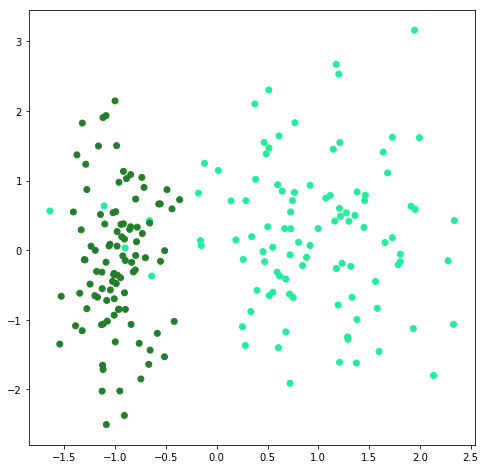

In [454]:
data, target = datasets.make_classification(n_samples=sample_size, n_features=2, 
                                            n_informative=1, n_redundant=0, 
                                            n_repeated=0, n_classes=2, 
                                            n_clusters_per_class=1, 
                                            weights=None, flip_y=0.01, 
                                            class_sep=1.0, hypercube=True, 
                                            shift=0.0, scale=1.0, 
                                            shuffle=True, random_state=2)
plot_2d_dataset_class([data, target])
plt.show()

### Split dataset into train & test samples

In [455]:
train_data, \
test_data, \
train_labels, \
test_labels = cross_validation.train_test_split(data, target, test_size = 0.3)

In [456]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[ 1.14684999  1.4511699 ]
 [ 0.80529423  0.11405388]
 [ 1.46275378  0.78905965]
 [-0.90002873 -0.8499955 ]
 [ 1.20818506  0.59982043]] 
...

train_labels: 
 [1 1 1 0 1] ...


# Run models and output

### Numerical method using gradient descent

/Users/Yaroslava/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # This is added back by InteractiveShellApp.init_path()


w:
 [ 11.28280027  24.78688555   4.71233703] 

true vs. prediction:
 [[1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 1]] 
...

accuracy:  0.979


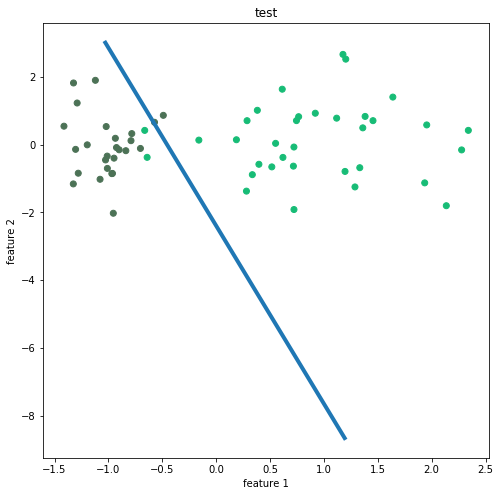

In [468]:
w = logistic_regression_fit(train_data, train_labels, 'grad_desc', eta = 0.5)

print_result(w,train_labels,logistic_regressor.predict(train_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')
elif train_data.shape[1] == 2:
    #plot_for_two_feature(train_data, train_labels, w, 'train')
    plot_for_two_feature(test_data, test_labels, w, 'test')

### Numerical method using stochastic gradient descent

/Users/Yaroslava/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  # Remove the CWD from sys.path while we load stuff.


w:
 [ 0.74104652  5.32414479  0.51976718] 

true vs. prediction:
 [[1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]] 
...

accuracy:  0.967


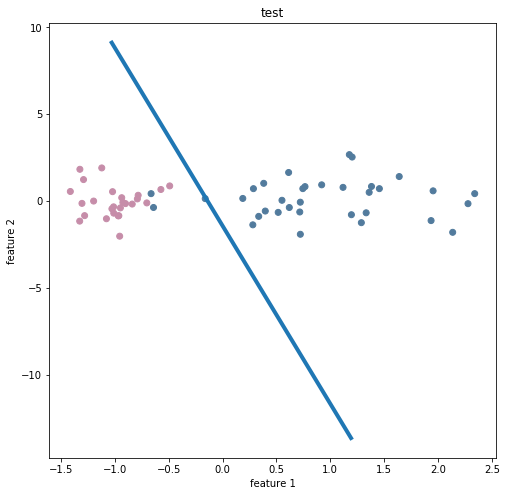

In [469]:
w = logistic_regression_fit(train_data, train_labels, 'st_grad_desc', eta=0.5)

print_result(w,test_labels,logistic_regressor.predict(test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')
elif train_data.shape[1] == 2:
    #plot_for_two_feature(train_data, train_labels, w, 'train')
    plot_for_two_feature(test_data, test_labels, w, 'test')

### Numerical method using scipy.optimize.minimize

w:
 [ 1.62848567  5.09229636  0.54352614] 

true vs. prediction:
 [[1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]] 
...

accuracy:  0.967


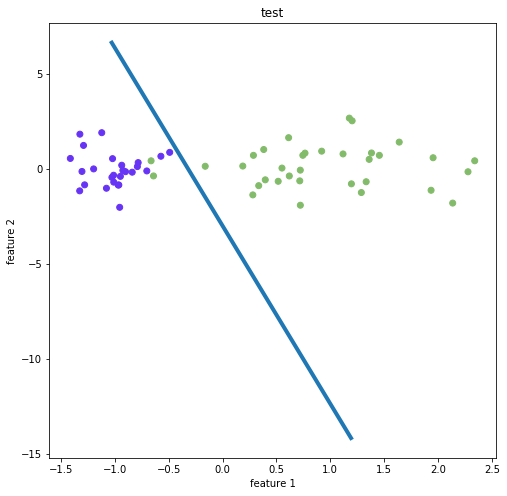

In [470]:
w = logistic_regression_fit(train_data, train_labels, 'scipy_minimize')

print_result(w,test_labels,logistic_regressor.predict(test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')
elif train_data.shape[1] == 2:
    #plot_for_two_feature(train_data, train_labels, w, 'train')
    plot_for_two_feature(test_data, test_labels, w, 'test')

### sklearn.linear_model.LogisticRegression for check

w:
 [ 0.4990988   3.16356276  0.52616345] 

true vs. prediction:
 [[1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]] 
...

accuracy:  0.967


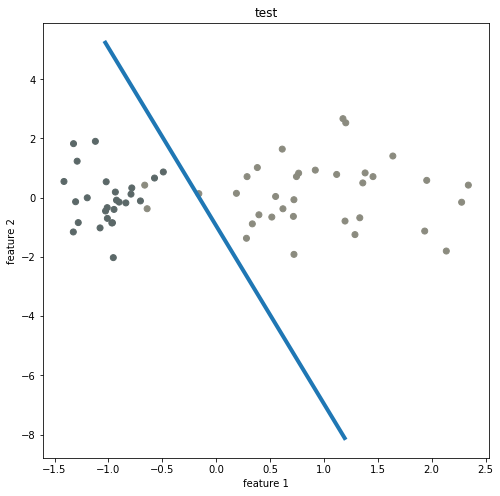

In [471]:
logistic_regressor = linear_model.LogisticRegression(penalty='l2', 
                                                     tol=1e-4,
                                                     fit_intercept=True, 
                                                     intercept_scaling=1, 
                                                     class_weight=None, 
                                                     random_state=1, 
                                                     solver='liblinear')
logistic_regressor.fit(train_data, train_labels)

w = [logistic_regressor.intercept_[0]]
w.extend(logistic_regressor.coef_[0])
w = np.array(w)
print_result(w,test_labels,logistic_regressor.predict(test_data))
if train_data.shape[1] == 1:
    #plot_for_one_feature(train_data, train_labels, w, 'train')
    plot_for_one_feature(test_data, test_labels, w, 'test')
elif train_data.shape[1] == 2:
    #plot_for_two_feature(train_data, train_labels, w, 'train')
    plot_for_two_feature(test_data, test_labels, w, 'test')